

### 📘**Experiment 0 — Synthetic Data Generation**


This experiment involves the construction of a synthetic dataset that closely replicates the structure and key statistical characteristics of the original municipal early-warning dataset. The synthetic data preserve identical column names and approximate empirical distributions for core variables, including debt amounts, recidivism, contact delays, and outcome measures such as reachability and acceptance of assistance. As a result, all computational procedures, visualizations, and statistical models can be executed under conditions that are representative of the original data.

The primary purpose of this experiment is to enable rigorous validation of the analytical pipeline prior to its application to real municipal datasets. Specifically, it facilitates systematic testing of the robustness, correctness, and interpretability of all subsequent analyses (Experiments 1–8). This includes verifying end-to-end notebook functionality, ensuring appropriate handling of missing values, and confirming the stability of feature engineering and modeling steps across varying data sizes and distributions. By validating the workflow using controlled synthetic inputs, this experiment establishes the reliability and reproducibility of the final methodology when deployed on sensitive, real-world municipal data.

In [24]:
import pandas as pd
import numpy as np

# Path to your original Excel (for schema + date range)
orig_path = "bi_export_12299_ XXLLNC.xlsx"  # adjust if needed
orig = pd.read_excel(orig_path)

orig_cols = orig.columns.tolist()
n_synth = 2000  # number of synthetic rows

# Start: empty frame with same columns
synth_full = pd.DataFrame(columns=orig_cols).reindex(range(n_synth))

# 1) Volgnummer
synth_full['Volgnummer'] = np.arange(1, n_synth + 1)

# 2) Gemeente (now we have 3 municipalities)
gemeenten = ['Gemeente Laaglanden', 'Gemeente Hoogstad', 'Gemeente Middenveen']
synth_full['Gemeente'] = np.random.choice(gemeenten, size=n_synth, p=[0.5, 0.3, 0.2])

# 3) Datum melding (random dates around your original range)
min_date = pd.to_datetime(orig['RIS Matching: Datum melding']).min()
max_date = pd.to_datetime(orig['RIS Matching: Datum melding']).max()
date_range_days = (max_date - min_date).days
rand_days = np.random.randint(0, max(date_range_days, 1) + 30, size=n_synth)
dates_signal = min_date + pd.to_timedelta(rand_days, unit='D')
synth_full['RIS Matching: Datum melding'] = dates_signal

# 4) Debt amount (lognormal, realistic)
orig_debt = (
    orig['RIS Matching: Achterstandsbedrag']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

raw_debt = np.random.lognormal(mean=np.log(400), sigma=1.0, size=n_synth)
raw_debt = np.clip(raw_debt, 1, 30000)
s_debt = np.round(raw_debt, 2)
synth_full['RIS Matching: Achterstandsbedrag'] = s_debt

# 5) Recidive (Ja/Nee)
recidive_flag = np.random.binomial(1, 0.45, size=n_synth)
synth_full['Recidive'] = np.where(recidive_flag == 1, 'Ja', 'Nee')

# 6) Generate contact dates (1st, 2nd, 3rd attempt)

# First attempt: 0–14 days after signal
first_delay = np.random.randint(0, 15, size=n_synth)
date_contact1 = dates_signal + pd.to_timedelta(first_delay, unit='D')
synth_full['Melder 1: startdatum contact'] = date_contact1

# Second attempt for ~30% of cases
has_second = np.random.binomial(1, 0.3, size=n_synth).astype(bool)
second_delay = first_delay + np.random.randint(2, 10, size=n_synth)
date_contact2 = dates_signal + pd.to_timedelta(second_delay, unit='D')
synth_full.loc[has_second, 'Melder 2: startdatum contact'] = date_contact2[has_second]

# Third attempt for ~15% of cases
has_third = np.random.binomial(1, 0.15, size=n_synth).astype(bool)
third_delay = second_delay + np.random.randint(2, 10, size=n_synth)
date_contact3 = dates_signal + pd.to_timedelta(third_delay, unit='D')
synth_full.loc[has_third, 'Melder 3: startdatum contact'] = date_contact3[has_third]

# Final contact date (used for ...Datum contact(poging) columns)
final_contact_date = pd.Series(date_contact1, index=synth_full.index)
final_contact_date[has_second] = date_contact2[has_second]
final_contact_date[has_third] = date_contact3[has_third]

# 7) Probability of being reached depends on:
#    - debt (higher -> slightly higher)
#    - recidive (Ja -> slightly lower)
#    - delay (longer -> lower)
base_p_reached = 0.55
debt_factor = (s_debt > 500).astype(float) * 0.05 + (s_debt > 5000).astype(float) * 0.05
recidive_factor = np.where(recidive_flag == 1, -0.05, 0.0)
delay_factor = -0.02 * (first_delay / 7.0)  # negative effect of delay

p_reached = np.clip(base_p_reached + debt_factor + recidive_factor + delay_factor, 0.05, 0.95)
reached_flag = np.random.binomial(1, p_reached)
synth_full['Eindresultaat: Persoon bereikt'] = np.where(reached_flag == 1, 'ja', None)

# 8) Probability of accepting help, conditional on reaching
base_p_help = 0.5
help_recidive_factor = np.where(recidive_flag == 1, 0.1, 0.0)
help_debt_factor = (s_debt > 2000).astype(float) * 0.1

p_help = np.clip(base_p_help + help_recidive_factor + help_debt_factor, 0.05, 0.95)
help_flag = np.where(reached_flag == 1, np.random.binomial(1, p_help), 0)
synth_full['Eindresultaat: Resultaat contact, Wil de klant hulp?'] = np.where(help_flag == 1, 'ja', None)

# 9) Fill all "...Contact(poging) en bereik, Datum contact(poging)" columns with final_contact_date
contact_poging_cols = [
    c for c in orig_cols if 'contact(poging) en bereik, datum contact(poging)' in c.lower()
]
for col in contact_poging_cols:
    synth_full[col] = final_contact_date

# Quick sanity check
synth_full[['RIS Matching: Datum melding',
            'Melder 1: startdatum contact',
            'Eindresultaat: Persoon bereikt']].head()


In [ ]:
synth_full.to_excel("bi_export_12299_XXLLNC_synthetic_with_contact.xlsx", index=False)
synth_full.to_csv("bi_export_12299_XXLLNC_synthetic_with_contact.csv", index=False)

In [3]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(file_path):
    """
    Load the Excel file into a DataFrame and prepare the debt column.
    """
    logging.info("Loading data...")
    data = pd.read_excel(file_path)
    logging.info(f"Data loaded with {data.shape[0]} rows and {data.shape[1]} columns.")

    # Make debt numeric
    data['RIS Matching: Achterstandsbedrag'] = (
        data['RIS Matching: Achterstandsbedrag']
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )
    logging.info("Converted 'RIS Matching: Achterstandsbedrag' to numeric format.")

    return data

In [4]:
file_path = "bi_export_12299_XXLLNC_synthetic_with_contact.xlsx"
data = load_data(file_path)

### 📘**Experiment 1 — Monthly Patterns in Reachability and Help Acceptance**

This experiment analyses outreach performance at the monthly level using the early-warning dataset. The date of each signal is first converted into a monthly time indicator, after which two binary outcome variables are constructed: whether the individual was successfully reached and whether assistance was accepted following contact.

The data are then aggregated by month to calculate the total number of signals, the number of individuals reached, and the number of cases in which help was accepted. Based on these monthly aggregates, two performance indicators are derived: the reach rate, defined as the proportion of signals that resulted in successful contact, and the help-acceptance rate conditional on reach, defined as the proportion of reached individuals who accepted assistance. Months in which no individuals were reached are handled explicitly to avoid undefined rate calculations.

To examine short-term changes over time, month-to-month differences in both rates are computed using first differences. In addition, three-month rolling averages are calculated to smooth short-term fluctuations and highlight more gradual changes in performance. The resulting monthly reach and conditional acceptance rates are visualized as time series to support descriptive comparison across months.

In [5]:

# 1) Date & month of signal
data['datum_melding'] = pd.to_datetime(
    data['RIS Matching: Datum melding'], errors='coerce'
)
data['signal_month'] = data['datum_melding'].dt.to_period('M').dt.to_timestamp()

# 2) Binary flags: reached & accepted help
data['reached'] = data['Eindresultaat: Persoon bereikt'].eq('ja').astype(int)
data['help_accepted'] = data['Eindresultaat: Resultaat contact, Wil de klant hulp?'].eq('ja').astype(int)

# Quick sanity check
data[['datum_melding', 'signal_month', 'reached', 'help_accepted']].head()

,datum_melding,signal_month,reached,help_accepted
0,2024-09-19,2024-09-01,0,0
1,2024-07-26,2024-07-01,0,0
2,2024-06-30,2024-06-01,1,1
3,2024-08-04,2024-08-01,0,0
4,2024-08-10,2024-08-01,0,0


In [6]:
# --- Monthly analysis (for 3.2) ---

monthly = (
    data.groupby('signal_month')
        .agg(
            n_signals=('Volgnummer', 'count'),
            n_reached=('reached', 'sum'),
            n_help_accepted=('help_accepted', 'sum'),
        )
)

monthly['reach_rate'] = monthly['n_reached'] / monthly['n_signals']

# Avoid division by zero for months where nobody was reached
denom = monthly['n_reached'].where(monthly['n_reached'] != 0)
monthly['acceptance_rate_given_reached'] = monthly['n_help_accepted'] / denom

monthly

,n_signals,n_reached,n_help_accepted,reach_rate,acceptance_rate_given_reached
signal_month,,,,,
2024-06-01,148,82,47,0.554054,0.573171
2024-07-01,704,391,206,0.555398,0.526854
2024-08-01,690,358,208,0.518841,0.581006
2024-09-01,458,234,121,0.510917,0.517094


In [13]:
# --- Month-over-Month Change ---

monthly_change = monthly.copy()
monthly_change['reach_rate_change'] = monthly_change['reach_rate'].diff().round(3)
monthly_change['acceptance_rate_change'] = monthly_change['acceptance_rate_given_reached'].diff().round(3)

display(monthly_change[['reach_rate', 'reach_rate_change',
                        'acceptance_rate_given_reached', 'acceptance_rate_change']])

print("\nInterpretation:")
print("• Positive values indicate improvement from the previous month.")
print("• Negative values indicate decline in outreach or acceptance performance.")
print("• Useful for pre/post intervention evaluation (e.g., new outreach strategies).")

,reach_rate,reach_rate_change,acceptance_rate_given_reached,acceptance_rate_change
signal_month,,,,
2024-06-01,0.554054,NaN,0.573171,NaN
2024-07-01,0.555398,0.001,0.526854,-0.046
2024-08-01,0.518841,-0.037,0.581006,0.054
2024-09-01,0.510917,-0.008,0.517094,-0.064



Interpretation:
• Positive values indicate improvement from the previous month.
• Negative values indicate decline in outreach or acceptance performance.
• Useful for pre/post intervention evaluation (e.g., new outreach strategies).


In [15]:
# --- Rolling Average Smoothing ---

monthly_smooth = monthly.copy()
monthly_smooth['reach_rate_smooth'] = monthly_smooth['reach_rate'].rolling(3, min_periods=1).mean()
monthly_smooth['acceptance_rate_smooth'] = monthly_smooth['acceptance_rate_given_reached'].rolling(3, min_periods=1).mean()

display(monthly_smooth[['reach_rate', 'reach_rate_smooth',
                        'acceptance_rate_given_reached', 'acceptance_rate_smooth']])

print("\nInterpretation:")
print("• The smoothed values highlight slower structural changes.")
print("• Useful for understanding long-term outreach performance.")

,reach_rate,reach_rate_smooth,acceptance_rate_given_reached,acceptance_rate_smooth
signal_month,,,,
2024-06-01,0.554054,0.554054,0.573171,0.573171
2024-07-01,0.555398,0.554726,0.526854,0.550012
2024-08-01,0.518841,0.542764,0.581006,0.560344
2024-09-01,0.510917,0.528385,0.517094,0.541651



Interpretation:
• The smoothed values highlight slower structural changes.
• Useful for understanding long-term outreach performance.


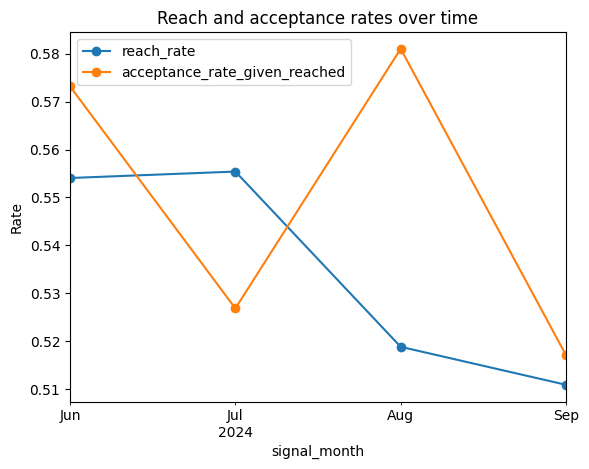

In [7]:
monthly[['reach_rate', 'acceptance_rate_given_reached']].plot(marker='o')
plt.ylabel("Rate")
plt.title("Reach and acceptance rates over time")
plt.show()

### 📘**Experiment 2 — Municipality-Level Outreach Performance**

This experiment summarises outreach outcomes at the municipality level. The data are grouped by municipality to compute the total number of early-warning signals, the number of individuals successfully reached, and the number of cases in which help was accepted.

On the basis of these municipality-level aggregates, two descriptive performance indicators are calculated: the reach rate, defined as the proportion of signals that resulted in successful contact, and the conditional help-acceptance rate, defined as the proportion of reached individuals who accepted assistance. Municipalities with zero reached cases are handled explicitly to avoid undefined acceptance-rate calculations.


In [8]:
# --- Per-municipality analysis (for 3.2) ---

by_gemeente = (
    data.groupby('Gemeente')
        .agg(
            n_signals=('Volgnummer', 'count'),
            n_reached=('reached', 'sum'),
            n_help_accepted=('help_accepted', 'sum'),
        )
)

by_gemeente['reach_rate'] = by_gemeente['n_reached'] / by_gemeente['n_signals']

denom2 = by_gemeente['n_reached'].where(by_gemeente['n_reached'] != 0)
by_gemeente['acceptance_rate_given_reached'] = by_gemeente['n_help_accepted'] / denom2

by_gemeente

,n_signals,n_reached,n_help_accepted,reach_rate,acceptance_rate_given_reached
Gemeente,,,,,
Gemeente Hoogstad,626,332,184,0.530351,0.554217
Gemeente Laaglanden,972,520,281,0.534979,0.540385
Gemeente Middenveen,402,213,117,0.529851,0.549296


### 📘**Experiment 3 — Logistic Regression of Reachability**

This experiment estimates a logistic regression model to examine how selected individual characteristics are associated with the probability of successful contact. The analysis constructs a binary recidivism indicator from the Recidive field and converts the registered arrears amount (RIS Matching: Achterstandsbedrag) into a numeric debt measure. Observations with missing values in either the outcome (reached) or the debt measure are excluded to ensure valid model estimation.

Using these prepared inputs, a logit model is fitted with reachability (reached) as the dependent variable and debt amount and recidivism status as predictors, including an intercept term. The model output (coefficients and associated inference statistics) is reported via the summary table, providing a multivariable description of how these predictors relate to the likelihood of reaching an individual.

In [9]:
import statsmodels.api as sm

reg_df = data.copy()

# Correct recidive flag
reg_df['recidive_flag'] = reg_df['Recidive'].astype(str).str.lower().eq('ja').astype(int)

# numeric debt
reg_df['debt_amount'] = pd.to_numeric(
    reg_df['RIS Matching: Achterstandsbedrag'], errors='coerce'
)

# use only valid rows
reg_df = reg_df.dropna(subset=['reached', 'debt_amount'])

# Ensure reached is an int
reg_df['reached'] = reg_df['reached'].astype(int)

X = reg_df[['debt_amount', 'recidive_flag']]
X = sm.add_constant(X)
y = reg_df['reached']

try:
    model = sm.Logit(y, X).fit()
    print(model.summary())
except Exception as e:
    print("Model could not be estimated:", e)

Optimization terminated successfully.
         Current function value: 0.689960
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                reached   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                0.001553
Time:                        16:51:20   Log-Likelihood:                -1379.9
converged:                       True   LL-Null:                       -1382.1
Covariance Type:            nonrobust   LLR p-value:                    0.1169
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1699      0.069      2.453      0.014       0.034       0.306
debt_amount    5.444

### 📘**Experiment 4 — Outreach Funnel Analysis**

This experiment presents a descriptive funnel analysis of the early-warning outreach process. The analysis counts the number of cases at successive stages of the intervention pipeline: total early-warning signals, cases for which a contact outcome is recorded (indicating that outreach was attempted), cases in which the individual was successfully reached, and cases in which help was ultimately accepted.

By comparing the number of observations at each stage, the funnel highlights where attrition occurs throughout the outreach process. Specifically, it distinguishes cases that do not progress to an attempted contact, cases in which contact is attempted but unsuccessful, and cases in which contact is established but assistance is not accepted.

The resulting funnel table provides a high-level overview of progression and drop-off across stages of the early-warning intervention, serving as a descriptive diagnostic of where losses occur within the outreach pipeline.

In [10]:
# --- Funnel Conversion Analysis ---

funnel = {
    "Total signals": len(data),
    "Contact attempted (non-null)": data['Eindresultaat: Persoon bereikt'].notna().sum(),
    "Reached (yes)": data['reached'].sum(),
    "Help accepted (yes)": data['help_accepted'].sum(),
}

funnel_df = pd.DataFrame.from_dict(funnel, orient='index', columns=['Count'])
display(funnel_df)

print("\nInterpretation:")
print("• The difference between total signals and contact-attempted shows how many cases never progressed to outreach.")
print("• The gap between contact-attempted and reached identifies cases where outreach was attempted but unsuccessful.")
print("• The final drop shows how many reached individuals actually accepted help.")

,Count
Total signals,2000
Contact attempted (non-null),1065
Reached (yes),1065
Help accepted (yes),582



Interpretation:
• The difference between total signals and contact-attempted shows how many cases never progressed to outreach.
• The gap between contact-attempted and reached identifies cases where outreach was attempted but unsuccessful.
• The final drop shows how many reached individuals actually accepted help.



### 📘**Experiment 5 — Debt Amount Segmentation**

This experiment examines outreach outcomes across predefined debt amount categories. The registered arrears amount is grouped into five bins representing increasing levels of debt. These categories are used to segment the dataset into distinct debt groups.

For each debt category, the mean values of the binary indicators for reachability and help acceptance are computed. These means correspond to the proportion of cases in each debt group that resulted in successful contact and the proportion that resulted in acceptance of assistance, respectively.

The resulting table provides a descriptive comparison of outreach outcomes across debt levels, allowing for assessment of whether reachability and help acceptance vary systematically with the size of the registered debt.

In [11]:
# --- Debt Amount Binning ---

# Create a clean alias if it doesn't exist
data['debt_amount'] = data['RIS Matching: Achterstandsbedrag']

data['debt_bin'] = pd.cut(
    data['debt_amount'],
    bins=[0, 250, 1000, 5000, 20000, float('inf')],
    labels=['<250', '250–1000', '1K–5K', '5K–20K', '20K+']
)

debt_results = data.groupby('debt_bin')[['reached', 'help_accepted']].mean().round(3)
display(debt_results)

print("\nInterpretation:")
print("• 'reached' shows the probability of reaching individuals in each debt category.")
print("• 'help_accepted' shows the probability of accepting assistance once reached.")
print("Use this to detect whether high-debt or low-debt individuals behave differently.")

/tmp/ipython-input-226757313.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  debt_results = data.groupby('debt_bin')[['reached', 'help_accepted']].mean().round(3)


,reached,help_accepted
debt_bin,,
<250,0.000,0.000
250–1000,0.500,0.333
1K–5K,0.512,0.224
5K–20K,0.517,0.279
20K+,0.541,0.301



Interpretation:
• 'reached' shows the probability of reaching individuals in each debt category.
• 'help_accepted' shows the probability of accepting assistance once reached.
Use this to detect whether high-debt or low-debt individuals behave differently.



### 📘**Experiment 6 — Recidivism Group Comparison**


This experiment assesses whether outreach outcomes differ between individuals flagged as recidivists and those not flagged as recidivists. A binary recidivism indicator is constructed from the Recidive field (coded as 1 for “ja” and 0 otherwise) when not already present in the dataset.

The analysis then aggregates the data by recidivism status and computes the mean of two binary outcome measures: reachability (reached) and help acceptance (help_accepted). These means correspond to the proportion of cases reached and the proportion of cases in which help was accepted within each group. The resulting summary table enables a direct descriptive comparison of outreach outcomes between recidivists and non-recidivists.

In [12]:
# --- Recidivism Effect Analysis ---

# 1. Create binary recidivism flag if not already present
if 'recidive_flag' not in data.columns:
    data['recidive_flag'] = data['Recidive'].astype(str).str.lower().str.strip().eq('ja').astype(int)

# 2. Calculate summaries
recidive_summary = (
    data.groupby('recidive_flag')[['reached', 'help_accepted']]
        .mean()
        .round(3)
)

# Rename rows for readability
recidive_summary.index = ['Non-recidivist (0)', 'Recidivist (1)']

display(recidive_summary)

print("\nInterpretation:")
print("• Compare the two rows: recidivists vs. non-recidivists.")
print("• Lower reach rate for recidivists → possible structural or behavioral barriers.")
print("• Lower help acceptance → may need tailored outreach.")
print("• Higher help acceptance → recidivists may already know the system and respond more readily.")

,reached,help_accepted
Non-recidivist (0),0.551,0.276
Recidivist (1),0.510,0.309



Interpretation:
• Compare the two rows: recidivists vs. non-recidivists.
• Lower reach rate for recidivists → possible structural or behavioral barriers.
• Lower help acceptance → may need tailored outreach.
• Higher help acceptance → recidivists may already know the system and respond more readily.




### 📘**Experiment 7 — Time-to-Contact and Association With Outcomes**

This experiment quantifies the time elapsed between the recorded signal date and the first available contact date and examines its association with outreach outcomes. The procedure first identifies candidate contact-date variables by automatically detecting dataset columns whose names contain both “contact” and “datum.” If at least one such column is present, the first detected contact-date field is parsed as a datetime variable and used to compute the delay in days (days_to_contact) relative to the signal date (datum_melding).

The analysis reports descriptive statistics for the resulting time-to-contact distribution and computes a correlation matrix between time-to-contact, reachability (reached), and help acceptance (help_accepted). These correlations provide a descriptive indication of whether longer delays tend to be associated with lower outreach success. If no eligible contact-date column is detected, the analysis is not executed.


In [14]:
# --- Time-to-Contact Analysis (auto-detect contact date columns) ---

# Find all columns that look like contact date fields
contact_date_cols = [c for c in data.columns if 'contact' in c.lower() and 'datum' in c.lower()]

print("Detected contact date columns:", contact_date_cols)

if len(contact_date_cols) > 0:
    # Use the first contact attempt
    col = contact_date_cols[0]

    data['datum_contact'] = pd.to_datetime(data[col], errors='coerce')
    data['days_to_contact'] = (data['datum_contact'] - data['datum_melding']).dt.days

    print("\nDescriptive statistics for time-to-contact:")
    display(data['days_to_contact'].describe())

    print("\nCorrelation with outcomes:")
    correlations = data[['days_to_contact', 'reached', 'help_accepted']].corr()
    display(correlations)

    print("\nInterpretation:")
    print("• Using contact date column:", col)
    print("• Negative correlations mean longer delays reduce success.")
else:
    print("No contact date columns found; skipping analysis.")

Detected contact date columns: ['Melder 1: startdatum contact', 'Melder 2: startdatum contact', 'Melder 3: startdatum contact', 'Eindresultaat: Contact(poging) en bereik, Datum contact(poging)', '1e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)', '2e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)', '3e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)', '4e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)', '5e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)', '6e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)', '7e tussenresultaat: Contact(poging) en bereik, Datum contact(poging)']

Descriptive statistics for time-to-contact:


,days_to_contact
count,2000.000000
mean,6.913000
std,4.334723
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,14.000000



Correlation with outcomes:


,days_to_contact,reached,help_accepted
days_to_contact,1.000000,-0.017885,-0.027780
reached,-0.017885,1.000000,0.600281
help_accepted,-0.027780,0.600281,1.000000



Interpretation:
• Using contact date column: Melder 1: startdatum contact
• Negative correlations mean longer delays reduce success.




### 📘**Experiment 8 — Help Acceptance Behaviour Analysis**


This experiment provides a descriptive and inferential analysis of help acceptance outcomes in the early-warning dataset. First, overall help acceptance is summarised by computing the proportion of cases in which assistance was accepted across the full sample, as well as the proportion among individuals who were successfully reached.

Next, help acceptance rates are calculated across several subgroup dimensions. Specifically, acceptance rates are summarised by municipality, and—where the relevant variables are available—by debt amount category and by recidivism status. These subgroup comparisons are based on mean values of the binary help-acceptance indicator and allow for descriptive assessment of variation in acceptance outcomes across different population segments.

In addition, a chi-square test of independence is conducted to assess whether there is a statistically significant association between being reached and accepting help. This test evaluates whether help acceptance and reachability are related beyond what would be expected by chance. Finally, help acceptance rates by municipality are visualised to facilitate comparison across local contexts.

In [26]:
# --- Experiment 2: Help Acceptance Behaviour Analysis ---

# 1. Overall metrics
overall_help_rate = data['help_accepted'].mean()
reached_help_rate = data.loc[data['reached'] == 1, 'help_accepted'].mean()

print(f"Overall help acceptance rate: {overall_help_rate:.3f}")
print(f"Help acceptance among reached individuals: {reached_help_rate:.3f}")

# 2. Acceptance by municipality
accept_by_muni = (
    data.groupby('Gemeente')['help_accepted']
        .mean()
        .sort_values(ascending=False)
)
display(accept_by_muni.to_frame('help_acceptance_rate'))

# 3. Acceptance by debt group (if available)
if 'debt_bin' in data.columns:
    accept_by_debt = (
        data.groupby('debt_bin')['help_accepted']
            .mean()
            .round(3)
    )
    display(accept_by_debt.to_frame('help_acceptance_rate_by_debt'))

# 4. Acceptance by recidivism
if 'recidive_flag' in data.columns:
    accept_by_recidive = (
        data.groupby('recidive_flag')['help_accepted']
            .mean()
            .round(3)
    )
    accept_by_recidive.index = ['Non-recidivist (0)', 'Recidivist (1)']
    display(accept_by_recidive.to_frame('help_acceptance_rate_by_recidive'))

# 5. Optional significance test: Do reached people accept help significantly more?
import scipy.stats as stats

contingency = pd.crosstab(data['reached'], data['help_accepted'])
chi2, p, _, _ = stats.chi2_contingency(contingency)

print("\nChi-square test:")
print(f"Chi2 = {chi2:.3f}, p-value = {p:.5f}")
if p < 0.05:
    print("→ Significant association: being reached strongly predicts help acceptance.")
else:
    print("→ No significant association (unexpected). Check data quality.")

Overall help acceptance rate: 0.291
Help acceptance among reached individuals: 0.546


,help_acceptance_rate
Gemeente,
Gemeente Hoogstad,0.293930
Gemeente Middenveen,0.291045
Gemeente Laaglanden,0.289095


/tmp/ipython-input-3626620977.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('debt_bin')['help_accepted']


,help_acceptance_rate_by_debt
debt_bin,
<250,0.000
250–1000,0.333
1K–5K,0.224
5K–20K,0.279
20K+,0.301


,help_acceptance_rate_by_recidive
Non-recidivist (0),0.276
Recidivist (1),0.309



Chi-square test:
Chi2 = 718.028, p-value = 0.00000
→ Significant association: being reached strongly predicts help acceptance.


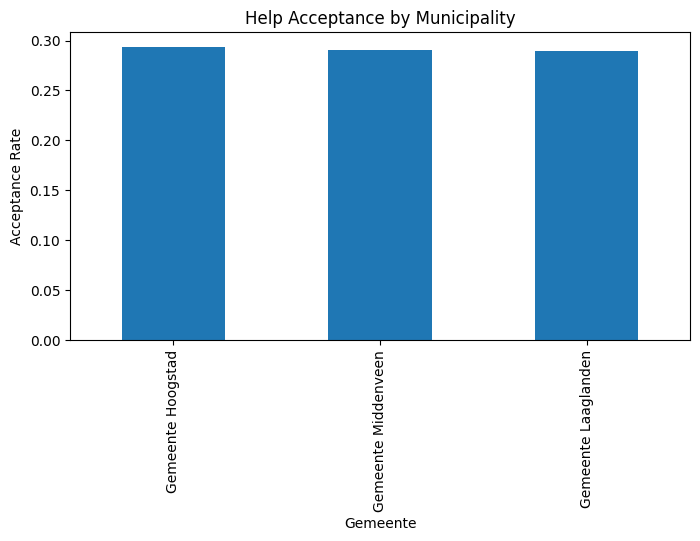

In [27]:
# Plot help acceptance by municipality
accept_by_muni.plot(kind='bar', figsize=(8,4), ylabel='Acceptance Rate',
                    title='Help Acceptance by Municipality')
plt.show()